In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score


%matplotlib inline

In [2]:
def convert_to_float(value):
    """
    Transforms argument value to float;
    Replaces the comma in a string variable with a dot and rounds the value to two decimal places;
    
    Parameters
    --------
    value: float
    
    Returns
    --------
    float
    
    """
    value = float(str(value).replace(",", "."))
    value = round(value, 2)
    return value

#######################################################################################################################

In [3]:
# Загрузка датафрейма из CSV файла;
cleared = pd.read_csv('../output/cleared.csv')

cleared = cleared[cleared['warp_dens'] < 40]

# Приведение типов колонок датафрейма к значению с плавающей запятой;
cleared['warp_a'] = cleared.warp_a.apply(convert_to_float)
cleared['warp_b'] = cleared.warp_b.apply(convert_to_float)
cleared['weft_a'] = cleared.weft_a.apply(convert_to_float)
cleared['weft_b'] = cleared.weft_b.apply(convert_to_float)
cleared['warp_mean'] = cleared.warp_mean.apply(convert_to_float)
cleared['weft_mean'] = cleared.weft_mean.apply(convert_to_float)
cleared['warp_dens'] = cleared.warp_dens.apply(convert_to_float)
cleared['weft_dens'] = cleared.weft_dens.apply(convert_to_float)

# Вычисление "усредненных" толщин нитей;
cleared['warp_nominal'] = round((cleared['warp_a'] + cleared['warp_b']) / 2, 2)
cleared['weft_nominal'] = round((cleared['weft_a'] + cleared['weft_b']) / 2, 2)

cleared['dens_coef'] = round(cleared['warp_dens'] / cleared['weft_dens'], 2)
cleared['thick_coef'] = round(cleared['warp_nominal'] / cleared['weft_nominal'], 2)

In [4]:
# "Синтетические" размеченные наборы;

#######################################################################################################################

# x_train = [
#     [0.25, 0.3, 36, 16], [0.30, 0.40, 26, 17], [0.25, 0.40, 26, 15 ], [0.30, 0.50, 27, 16],
#     [0.35, 0.35, 14, 9], [0.40, 0.40, 24, 13], [0.40, 0.40, 16, 2], [0.40, 0.30, 20, 12],
#     [0.80, 0.50, 10, 7], [0.50, 0.30, 10, 7], [0.70, 0.60, 8, 6], [0.50, 0.70, 8, 5]]

# y_train = [
#     1, 1, 1, 1,
#     2, 2, 2, 2,
#     3, 3, 3, 3
# ]

#######################################################################################################################

x_train = [
    [0.25, 0.32, 36, 16], [0.27, 0.35, 26, 17], [0.25, 0.40, 26, 15 ], [0.31, 0.40, 27, 16],
    [0.35, 0.35, 14, 11], [0.40, 0.40, 22, 13], [0.40, 0.40, 15, 10], [0.40, 0.52, 20, 12],
    [0.80, 0.50, 10, 7], [0.50, 0.30, 10, 7], [0.70, 0.60, 8, 6], [0.50, 0.77, 8, 5]]

y_train = [
    1, 1, 1, 1,
    2, 2, 2, 2,
    3, 3, 3, 3
]

#######################################################################################################################

# x_train = [
#     [0.25, 0.3, 36, 16], [0.25, 0.40, 26, 17], [0.25, 0.35, 26, 15 ], [0.15, 0.30, 27, 16],
#     [0.35, 0.35, 14, 9], [0.40, 0.40, 24, 13], [0.40, 0.40, 16, 2], [0.40, 0.30, 20, 12],
#     [0.80, 0.50, 10, 7], [0.55, 0.30, 10, 7], [0.70, 0.60, 8, 6], [0.50, 0.70, 8, 5]]

# y_train = [
#     1, 1, 1, 1,
#     2, 2, 2, 2,
#     3, 3, 3, 3
# ]

In [12]:
parameters = {
    'n_estimators': range(5, 30, 5),
    'max_depth': range(1, 10, 1),
#     'min_sample_leaf': range(1, 3),
#     'min_samples_split': range(1, 3),
}

grid = GridSearchCV(RandomForestClassifier(), parameters, cv=3)

grid.fit(x_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [13]:
grid.best_params_

{'max_depth': 1, 'n_estimators': 15}

In [14]:
clf_rf = RandomForestClassifier(n_estimators=15, max_depth=1)

In [15]:
clf_rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=1, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=15,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [16]:
classes = []

for index, row in cleared.iterrows():
    item_class = clf_rf.predict([[row.warp_nominal, row.weft_nominal, row.warp_dens, row.weft_dens]])
    classes.append(item_class[0])

In [17]:
cleared['classes'] = classes

In [18]:
class_1 = cleared[cleared['classes'] == 1]
class_2 = cleared[cleared['classes'] == 2]
class_3 = cleared[cleared['classes'] == 3]

In [19]:
print(len(class_1))
print(len(class_2))
print(len(class_3))

4
174
95


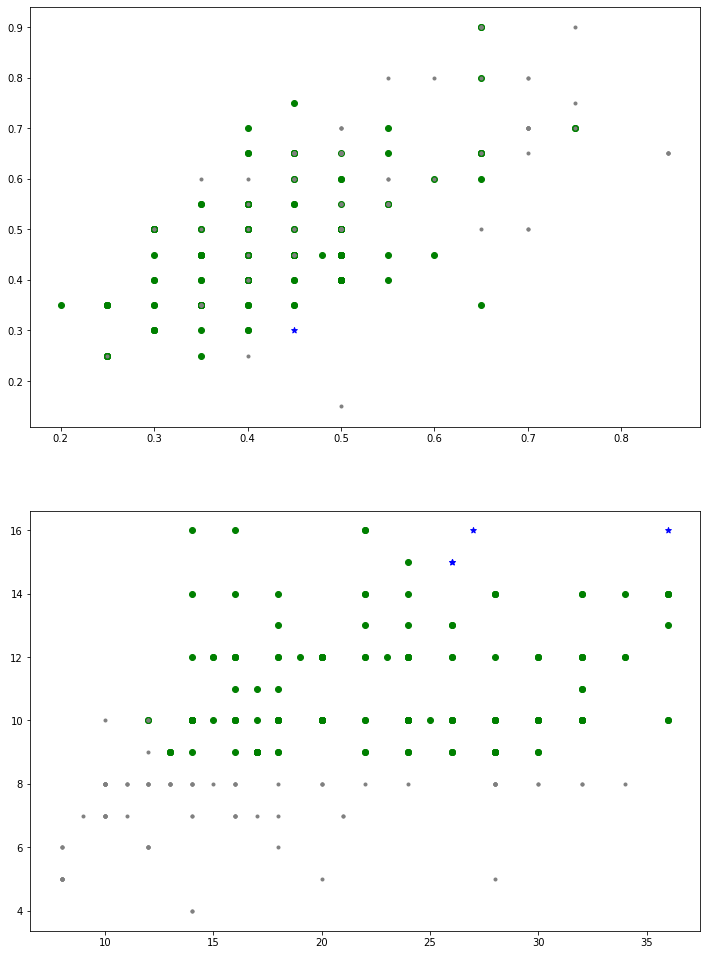

In [20]:
fig, ax = plt.subplots(2, 1, figsize=(12, 17))

ax[0].scatter(class_1['warp_nominal'].tolist(), class_1['weft_nominal'].tolist(), marker='*', color='blue')
ax[0].scatter(class_2['warp_nominal'].tolist(), class_2['weft_nominal'].tolist(), marker='o', color='green')
ax[0].scatter(class_3['warp_nominal'].tolist(), class_3['weft_nominal'].tolist(), marker='.', color='gray')

ax[1].scatter(class_1['warp_dens'].tolist(), class_1['weft_dens'].tolist(), marker='*', color='blue')
ax[1].scatter(class_2['warp_dens'].tolist(), class_2['weft_dens'].tolist(), marker='o', color='green')
ax[1].scatter(class_3['warp_dens'].tolist(), class_3['weft_dens'].tolist(), marker='.', color='gray')

plt.show()

In [21]:
persent_two = class_2.query('warp_dens >= 12 and warp_dens < 25 and weft_dens >= 9 and weft_dens < 15')

In [22]:
print(len(persent_two))

106


In [23]:
for number, class_item in enumerate([class_1, class_2, class_3]):
    print()
    print("Класс " + str(number) + ":")
    print("всего элементов - " + str(len(class_item)))
    print("среднее значение плотности по основе - " + str(round(class_item.warp_dens.mean(), 2)))
    print("минимальное значение плотности по основе - " + str(round(class_item.warp_dens.min(), 2)))
    print("максимальное значение плотности по основе - " + str(round(class_item.warp_dens.max(), 2)))
    print("среднее значение плотности по утку - " + str(round(class_item.weft_dens.mean(), 2)))
    print("минимальное значение плотнсти по утку - " + str(round(class_item.weft_dens.min(), 2)))
    print("максимальное значение плотности по утку - " + str(round(class_item.weft_dens.max(), 2)))
    print("=========================")


Класс 0:
всего элементов - 4
среднее значение плотности по основе - 28.75
минимальное значение плотности по основе - 26.0
максимальное значение плотности по основе - 36.0
среднее значение плотности по утку - 15.5
минимальное значение плотнсти по утку - 15.0
максимальное значение плотности по утку - 16.0

Класс 1:
всего элементов - 174
среднее значение плотности по основе - 22.64
минимальное значение плотности по основе - 12.0
максимальное значение плотности по основе - 36.0
среднее значение плотности по утку - 10.9
минимальное значение плотнсти по утку - 9.0
максимальное значение плотности по утку - 16.0

Класс 2:
всего элементов - 95
среднее значение плотности по основе - 15.05
минимальное значение плотности по основе - 8.0
максимальное значение плотности по основе - 34.0
среднее значение плотности по утку - 7.31
минимальное значение плотнсти по утку - 4.0
максимальное значение плотности по утку - 10.0


In [24]:
features = ['warp_dens', 'weft_dens', 'warp_nominal', 'weft_nominal', 'classes']

In [25]:
class_1 = class_1[features]
class_2 = class_2[features]
class_3 = class_3[features]

In [27]:
class_1.to_csv('../output/classification/class_1.csv')
# class_1.to_excel('../output/classification/class_1.xls')

class_2.to_csv('../output/classification/class_2.csv')
# class_2.to_excel('../output/classification/class_2.xls')

class_3.to_csv('../output/classification/class_3.csv')
# class_3.to_excel('../output/classification/class_3.xls')